## Init & utils

In [ ]:
# !tar -xvzf pr_4.tgz | wc -l

In [ ]:
import collections

from jsonpath_rw import jsonpath, parse
import jsonpath_rw_ext as jsonp

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import json 
from json import JSONEncoder, JSONDecoder
import pickle

class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (list, dict, str, unicode, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct

def save_to_json_file(filename, content):
    temp = json.dumps(content, cls=PythonObjectEncoder)
    with open(filename, 'w') as file:
        file.write(temp)
    return "saved " + filename    

def load_from_json_file(file_name):
    with open(file_name) as f:
        return json.load(f, object_hook=as_python_object)

In [ ]:
def cached_to_disk(data_provider, file_name):
    if os.path.exists(file_name):
        return load_from_json_file(file_name)
    else:
        result = data_provider()
        save_to_json_file(file_name, result)
        return result        

In [ ]:
import copy

def inc_dict_val(d, k, v):
    d[k] = int(d.get(k, 0)) + int(v)

def alter_dict(D, **F):
    result = copy.deepcopy(D)    
    result.update(**F)
    return result   

def map_dict(src, *args, **kvargs):
    dst = dict()
    for v in args:
        dst[v] = src[v]
    for k,v in kvargs.items():
        dst[k] = src[v]
    return dst

def remove_from_dict(d, key):
    if key in d:
        del d[key]

In [ ]:
from IPython.display import Audio

class InvisibleAudio(Audio):
    def _repr_html_(self):
        audio = super()._repr_html_()
        audio = audio.replace('<audio', f'<audio onended="this.parentNode.removeChild(this)"')
        return f'<div style="display:none">{audio}</div>'

def notify(sound_file = './notify.mp3'):
    display(InvisibleAudio(sound_file, autoplay=True))

## Printing

In [ ]:
from pprint import pprint
from IPython.display import JSON

width = 180
def print_line(char=' '):
    print(char*width)

In [ ]:
import re

def print_log(log, consumer=print, **args):
    if log:
        params = {g:'' for g in re.findall('\$\{([^}]+)\}', log)}
        params.update(args)
        consumer(log.replace('$', '').format(**params))

In [ ]:
from jsondiff import diff

def print_diff(old_dict, new_dict, consumer=print):     
    consumer(get_diff(old_dict, new_dict))
    
def get_diff(old_dict, new_dict):     
    return diff(old_dict, new_dict, syntax='symmetric')

In [ ]:
points = [1, 5, 20, 100, 500, 100]

import sys
import time
from datetime import datetime

def print_progress(i, timer_log=None, total=None):
    if (i % points[0] == 0):
        if i > 0 and (i % points[1] == 0):
            sys.stdout.write(' ')
            if (i % points[2] == 0):
                sys.stdout.write('  ')
                if (i % points[3] == 0):
                    if total:                            
                        timer_log = print_stats(total, i, points[5], timer_log)
                    else:
                        sys.stdout.write('\n')
                    if (i % points[4] == 0):
                        sys.stdout.write('\n')
        sys.stdout.write('.')
        sys.stdout.flush()   
    return timer_log
        
def print_stats(total, processed, bunch, last_time, **kwargs):
    now = time.time()
    speed = (now - last_time) / 60.0
    eta = (now - last_time) * (total - processed) / bunch
    print('eta: {eta:%M:%S} ({speed:.1f} min/{bunch})'.format(speed = speed, eta = datetime.fromtimestamp(eta), bunch=bunch))
    return now

def with_progress(l, size=None):
    timer_log = time.time()
    for i,v in enumerate(l):
        timer_log = print_progress(i, timer_log, size)
        yield v
    notify()

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding-right: 100px;"'),raw=True)

## Data manipulations

In [ ]:
def collect_data(files, collector):
    for f in files:
        data = load_from_json_file(f)
        data['file_name'] = f
        yield collector(data)

def flattern(data):
    return [l2 for l1 in data for l2 in l1]

def get_nodes(data, ptr):
    return list(select_all(ptr)(data))

In [ ]:
def select_all(key):
    return lambda data: jsonp.match(key, data)

def select_one(key):
    return lambda data: jsonp.match1(key, data)

def contains(key, value):
    return lambda data: jsonp.match1(key, data) == value

def all_of(*filters):
    def fn(data):
        for f in filters:
            if not f(data):
                return False
        return True  
    return fn

In [ ]:
def for_each(data, *funs):
    for fun in funs:
        data = fun(data)
    return data

In [ ]:
def copy_ids(src, dst):
    dst['table_id']  = src['table']
    dst['file_name'] = src['file_name']
    return dst    

def get_logs(data):
    result = select_one('$[*].log.data.data')(data)
    copy_ids(data, result)
    return result

def get_stats(data):
    result = select_one('$..data[?(@.type == "gameStateChange" & @.args.action == "stGameEnd")].args.args')(data)
    copy_ids(data, result)
    return result

In [ ]:
def steps(log):
    for move_id, move in enumerate(log):
        for sub_move_id, sub_move in enumerate(move['data']):
            yield sub_move

## Prepare data

In [ ]:
%load_ext memory_profiler
%load_ext autotime

In [ ]:
from os import listdir
from os.path import isfile, join

game = 'pr'
games = [join(game, f) for f in listdir(game) if f.endswith('.json')]
games.sort(reverse=True)
len(games)

In [ ]:
# from functools import lru_cache

# @lru_cache(maxsize=2)
def stats(sz = 1000): 
    return collect_data(with_progress(games[:sz], sz), get_stats)

# @lru_cache(maxsize=2)
def logs(sz = 1000):
    return collect_data(with_progress(games[:sz], sz), get_logs)

In [ ]:
stats_cache = cached_to_disk(lambda: list(stats()), 'stats.json')

In [ ]:
f = games[1]
data1 = load_from_json_file(f)
game_log = data1['log']['data']['data']['data']
stat = game_log[-1]['data'][-2]['args']['args']
JSON(stat)

# ACTIVE DEVELOPMENT ZONE

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
def countGovernors(log):
    return 1+sum([1 for s in steps(log['data']) if s['type'] == 'newGovernor'])

In [ ]:
g = cached_to_disk(lambda: [countGovernors(l) for l in logs()], 'governors.json')

In [ ]:
s = [float(s['table']['stats']['2']) for s in stats_cache]

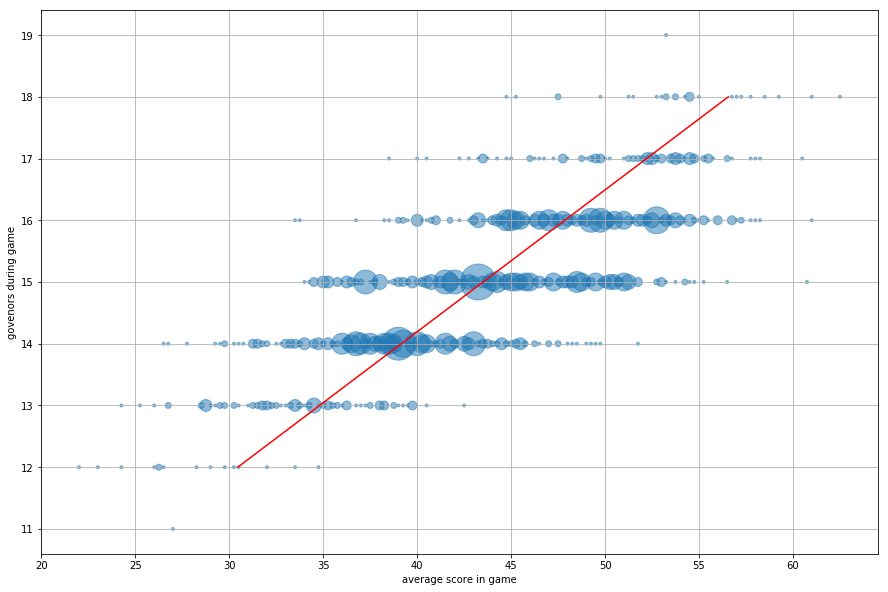

time: 924 ms


In [48]:
c = collections.Counter(zip(s, g))
sta_, gov_, sz = zip(*[(k[0], k[1], (3*v)**2) for k,v in c.items()])
sta_, gov_ = np.array(sta_), np.array(gov_)

fig, ax = plt.subplots()
ax.scatter(sta_, gov_, s=sz, alpha=.5)
ax.grid(True)
ax.set_xlabel('average score in game')
ax.set_ylabel('govenors during game')


ly = np.array([12, 18])
nps = np.array(s)
trend = np.polyfit(np.array(g), nps, 1)
ax.plot(trend[0]*ly + trend[1], ly, 'r')

plt.show()

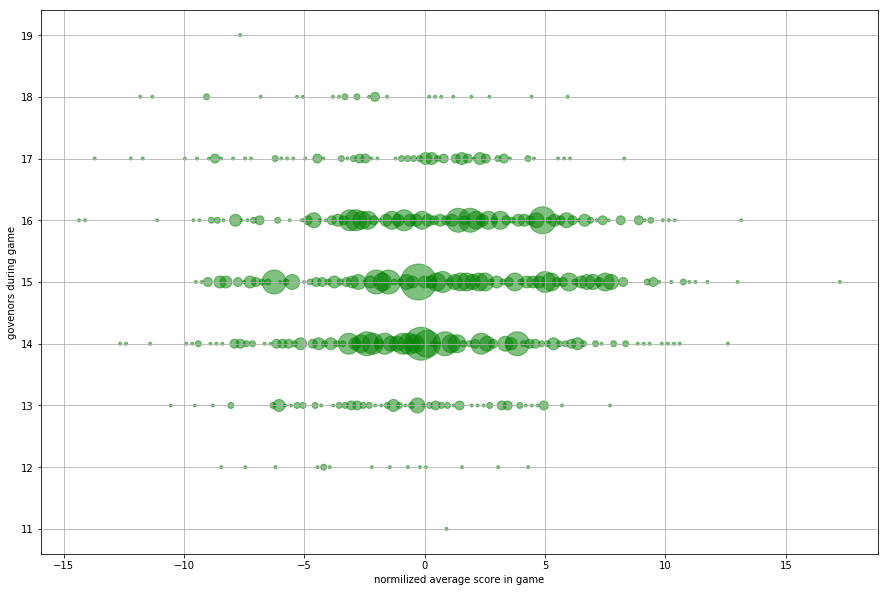

time: 921 ms


In [49]:
sta_2 = sta_ - gov_*trend[0] - trend[1]

fig, ax = plt.subplots()
ax.scatter(sta_2, gov_, s=sz, c='g', alpha=.5)
ax.grid(True)
ax.set_xlabel('normilized average score in game')
ax.set_ylabel('govenors during game')

plt.show()

Average Score on the table


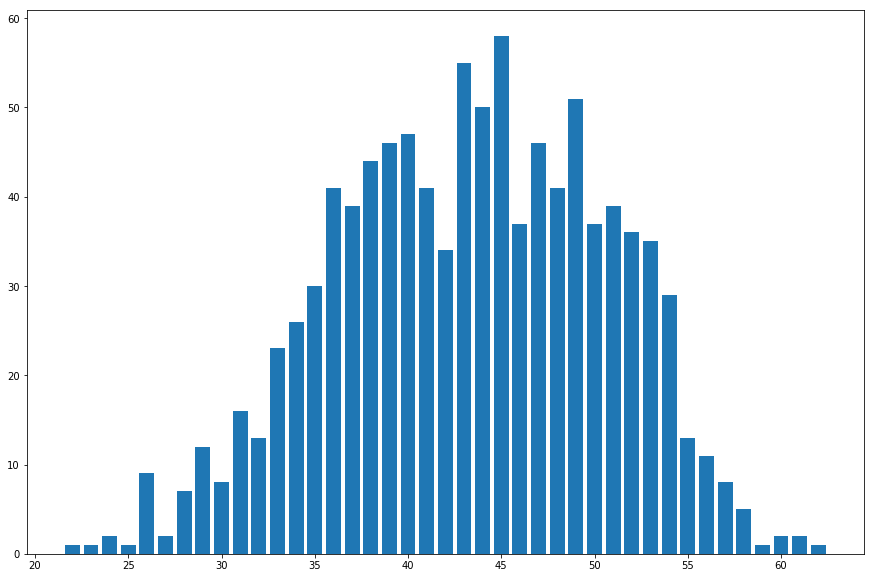

time: 830 ms


In [52]:
# avg = [int(p['table']['stats']['2']) for p in stats]
avg = [int(p) for p in s]
count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])
print('Average Score on the table')
plt.show()

Normalized Score on the table


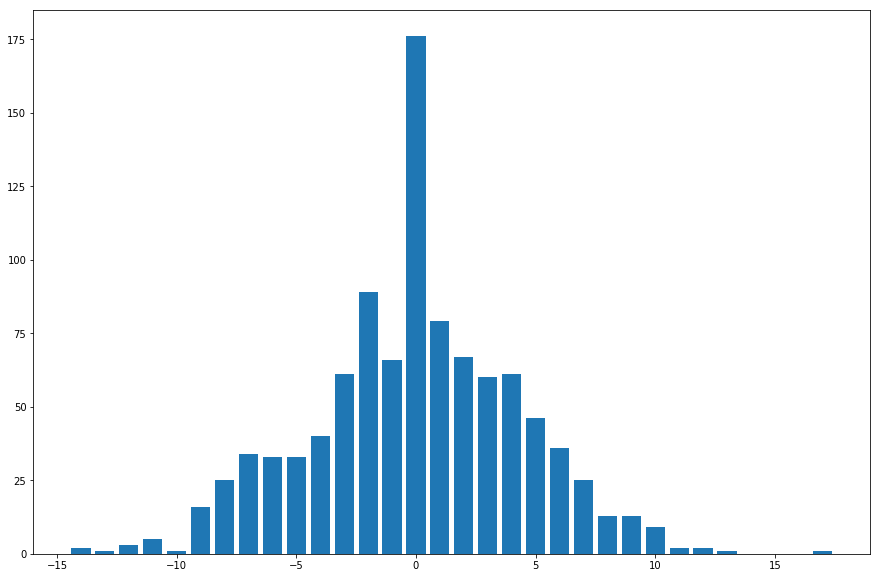

time: 759 ms


In [53]:
avg = [int(p - g[i]*trend[0] - trend[1]) for i,p in enumerate(s)]

count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])
print('Normalized Score on the table')
plt.show()

In [27]:
dd = [(
    int(p['rank']),
    int(p['stats']['10']),
    int(p['stats']['11']),     
#     int(p['stats']['12'])    
) for game in stats_cache for p in game['result']]

time: 60.1 ms


In [59]:
d = list(zip(*[(*k, v*v*10) for k,v in collections.Counter(dd).items()]))

time: 4.21 ms


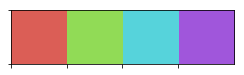

time: 1.58 s


In [62]:
import seaborn as sns
sns.palplot(sns.color_palette("hls", 4))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(d[1], d[2], c=d[0],  s=d[3], alpha=0.7, cmap=plt.get_cmap('hls'))
ax.grid(True)
plt.show()

## PICKED ROLES

In [ ]:
def countRoles(log):
    lst = [(s['args']['player_name'], s['args']['rol_type']) for s in steps(log) if s['type'] == 'roleSelected']
    result = [{'name': k[0], 'role':k[1], 'count':c} for k,c in collections.Counter(lst).items()]
    return result

In [ ]:
pd.DataFrame([countRoles(l) for l in logs]).head(4)

## STATS EXAMPLE

In [29]:
table_stats = {
     '1': '_',
     '4': 'Game duration',
     '3': 'Players average level',
     '2': 'Average score',
    '10': 'Unclaimed victory points',
    '11': 'Unclaimed colonists',
    '12': 'Doubloons in the bank',
    '13': 'Unclaimed plantations',
    '14': 'Unclaimed quarries',
    '15': 'Unclaimed small buildings',
    '16': 'Unclaimed large buildings'}

player_stats = {
     '1': 'Thinking time',
    '10': 'VPs earned by shipping',
    '11': 'VPs earned by building',
    '12': 'VPs earned from large buildings',
    '13': 'Doubloons owned at game end',
    '14': 'Good barrels owned at game end',
    '15': 'Colonists',
    '16': 'Plantations',
    '17': 'Quarries',
    '18': 'Small buildings',
    '19': 'Large buildings'}

tdf = pd.DataFrame([table_stats, stat['table']['stats']]).T
pdf = pd.DataFrame(
    data  = [player_stats] + [x['stats']  for x in stat['result']], 
    index =       ['name'] + [x['player'] for x in stat['result']]
).T

display_side_by_side(pdf, tdf)

,name,84883054,84886155,84411056,84896724
1,Thinking time,8.3,9.23334,11.8,11.8167
10,VPs earned by shipping,17,20,10,16
11,VPs earned by building,23,17,18,13
12,VPs earned from large buildings,15,5,5,0
13,Doubloons owned at game end,2,0,4,4
14,Good barrels owned at game end,1,1,2,0
15,Colonists,17,17,20,16
16,Plantations,5,6,5,4
17,Quarries,2,1,2,3
18,Small buildings,6,7,7,7


In [62]:
df_table = json_normalize(data=stats_cache).drop(columns=['result', 'file_name']).set_index('table_id')
df_table.head(5)

,table.concede,table.disagreement,table.neutralized,table.stats.1,table.stats.10,table.stats.11,table.stats.12,table.stats.13,table.stats.14,table.stats.15,table.stats.16,table.stats.2,table.stats.3,table.stats.4
table_id,,,,,,,,,,,,,,
40565834,False,False,0,4,21,11,59,13,0,19,0,43.25,62,177
41422564,False,False,0,4,66,5,60,14,2,20,0,30.75,44,149
41461557,False,False,0,4,23,5,73,12,0,16,0,44.75,52,182
41463045,False,False,0,4,23,1,73,20,2,12,0,49.00,55,181
41502058,False,False,0,4,4,1,56,18,0,16,0,50.75,57,192


time: 340 ms


In [61]:
df_player = json_normalize(data=stats_cache, record_path=['result'], meta='table_id')
df_player = pd.concat([df_player.drop(columns=['stats', 'color', 'color_back']), pd.DataFrame(df_player['stats'].tolist())], axis=1).set_index(['table_id', 'player'])
df_player.head(12)

concede            name  rank score score_aux    tie  \
table_id player                                                           
40565834 84685094        0           nmego     1    62         6  False   
         83971908        0             Pya     2    40         7  False   
         23240036        0        Ringking     3    37         7  False   
         84011443        0  cloudedcrystal     4    34        11  False   
41422564 4584848         0         kandale     1    44         7  False   
         84840595        0           Slift     2    43         4  False   
         84841138        0     sow00mill00     3    18        12  False   
         84765593        0             Eic     4    18         6  False   
41461557 1069424         0        ctcheung     1    52         2  False   
         84222461        0         Imanhol     2    48         0  False   
         84485493        0       suburbius     3    42         6  False   
         84755943        0          Fimera     4    37         2  False   

                   zombie        1  10  11  12  13 14  15  16 17 18 19  
table_id player                                                         
40565834 84685094       0    31343  23  22  17   6  0  15  10  2  5  3  
         83971908       0  56181.3  26  14   0   6  1  15   9  2  8  0  
         23240036       0  17027.6  14  17   6   6  1  18  10  1  6  1  
         84011443       0  67427.4  16  14   4   9  2  20   8  3  6  1  
41422564 4584848        0  31061.8  15  20   9   6  1  16   8  2  6  2  
         84840595       0  18384.7   6  21  16   3  1  20   9  1  5  3  
         84841138       0  32993.6   8  10   0  10  2  21   8  2  6  0  
         84765593       0  22730.4   5  13   0   6  0  17  11  1  7  0  
41461557 1069424        0  33060.2  21  20  11   2  0  18  12  0  8  2  
         84222461       0  22635.3  10  24  14   0  0  18   8  3  6  3  
         84485493       0  33014.3  24  18   0   6  0  20   9  3  8  0  
         84755943       0  16496.2  22  15   0   2  0  18   9  2  6  0

time: 196 ms


In [28]:
pprint(stat, width=width)

{'result': [{'color': '0000ff',
             'color_back': None,
             'concede': 0,
             'name': 'djk8',
             'player': '84883054',
             'rank': 1,
             'score': '55',
             'score_aux': '3',
             'stats': {'1': '8.3', '10': '17', '11': '23', '12': 15, '13': '2', '14': '1', '15': '17', '16': '5', '17': '2', '18': '6', '19': '3'},
             'tie': False,
             'zombie': 0},
            {'color': 'ffa500',
             'color_back': None,
             'concede': 0,
             'name': 'plummeting_sloth',
             'player': '84886155',
             'rank': 2,
             'score': '42',
             'score_aux': '1',
             'stats': {'1': '9.23334', '10': '20', '11': '17', '12': 5, '13': '0', '14': '1', '15': '17', '16': '6', '17': '1', '18': '7', '19': '1'},
             'tie': False,
             'zombie': 0},
            {'color': 'ff0000',
             'color_back': None,
             'concede': 0,
           

In [ ]:
group = ['scoreShippingPoints', 'scoreConditionalPoints', 'scoreEndPoints', 'buildingBought']
selected = [s for s in steps(game_log) if s['type'] in group]
argsByType = lambda t: [s['args'] for s in selected if s['type'] == t]

buildings = {s['bld_id']: {
    'player_id': s['player_id'], 
    'building': s['bld_type_tr'],
    'score': int(s['score_delta'])
} for s in argsByType('buildingBought')}

buildings_score = {}
for b in buildings.values():
    buildings_score.setdefault(b['player_id'], 0)
    buildings_score[b['player_id']] += b['score']

JSON({
    'shipping'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreShippingPoints')},
    'conditional': {s['building_name']: {
        s['player_id']: int(s['score_delta'])
    } for s in argsByType('scoreConditionalPoints')},
    'endScore'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreEndPoints')},
    'buildings_s': buildings_score,
    'buildings'  : buildings
}, width=width)

In [ ]:
flat = [s for s in steps(game_log) if s['type'] not in ['gameStateChange', 'message', 'updateReflexionTime']]
c = collections.Counter([s['type'] for s in flat])
c.most_common(20)